Dataset includes 721 types of pokemon with respective scores on their offensive and defensive metrics.

Question: based on the a specific set of features, can we determine whether or not the pokemon is legendary?

In [46]:
from sklearn import datasets, neighbors, metrics
import pandas as pd
import json
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

Below is the description of the fields in the dataset:
#: ID for each pokemon
Name: Name of each pokemon
Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
Type 2: Some pokemon are dual type and have 2
Total: sum of all stats that come after this, a general guide to how strong a pokemon is
HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
Attack: the base modifier for normal attacks (eg. Scratch, Punch)
Defense: the base damage resistance against normal attacks
SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
SP Def: the base damage resistance against special attacks
Speed: determines which pokemon attacks first each round

In [47]:
df_raw = pd.read_csv('pokemon.csv')
df_raw.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [49]:
#dropping number and name because it has not significance on the dataset
df = df_raw.drop(['#','Name'],1)
df.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Fire,NaN,309,39,52,43,60,50,65,1,False


In [50]:
df.corr()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
Total,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758
HP,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


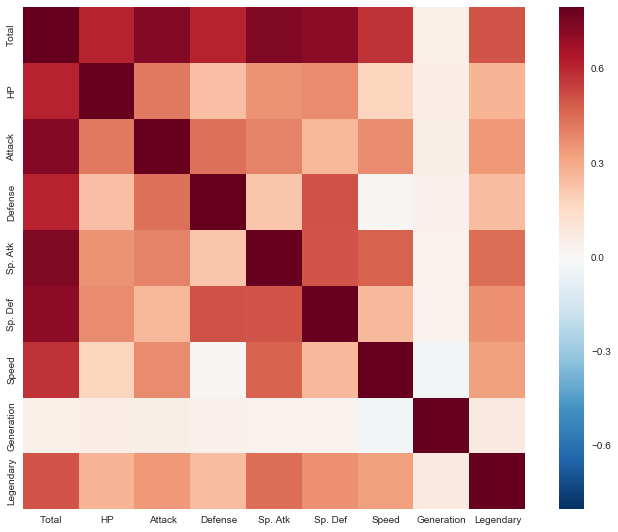

In [51]:
#correlation heatmap
import seaborn as sns
corrmat = df.corr()

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True)

Findings: Generation is not a strong feature.  There seems to be a stronger relationship between Special Attack and Special Defense

In [52]:
#Getting a summary of the basic stats
df.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


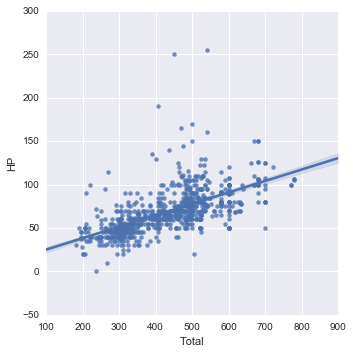

In [53]:
sns.lmplot('Total', 'HP', df)

In [54]:
log_columns = ['Total', 'HP',]
log_df = df.copy()
log_df[log_columns] = log_df[log_columns].apply(np.log10)

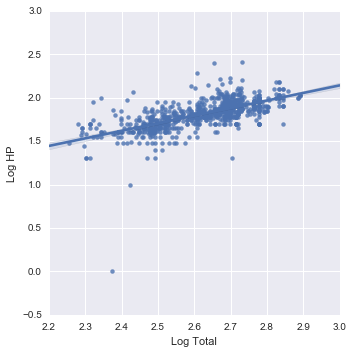

In [55]:
g = sns.lmplot('Total', 'HP', log_df)
g.set_axis_labels( "Log Total", "Log HP")

In [56]:
# Looking at the min and max within each bucket to see what should the threshold be for the classifier

df.groupby(['Legendary', 'Type 1']).min()

Type 2  Total   HP  Attack  Defense  Sp. Atk  Sp. Def  \
Legendary Type 1                                                              
False     Bug            inf    194    1      10       30       10       20   
          Dark           inf    220   35      50       30       30       30   
          Dragon         inf    300   41      50       35       30       30   
          Electric       inf    205   20      30       15       35       32   
          Fairy          inf    218   35      20       28       40       40   
          Fighting       inf    210   30      35       30       20       30   
          Fire           inf    250   38      30       37       15       40   
          Flying      Dragon    245   40      30       35       45       40   
          Ghost          inf    275   20      30       30       30       33   
          Grass          inf    180   30      27       30       24       30   
          Ground         inf    265   10      40       25       20       30   
          Ice            inf    250   36      30       15       30       30   
          Normal         inf    190   30       5        5       15       20   
          Poison         inf    245   35      43       35       30       40   
          Psychic        inf    198   20      20       15       23       35   
          Rock           inf    280   30      40       40       10       25   
          Steel          inf    300   40      24       50       24       37   
          Water          inf    200   20      10       20       10       20   
True      Dark           inf    600   70      90       90      131       90   
          Dragon    Electric    600   80      80       80       81       90   
          Electric       inf    580   79      85       70      115       80   
          Fairy          NaN    680  126     131       95      131       98   
          Fire           inf    580   80      90       85       90       75   
          Flying         NaN    580   79     100       70      110       80   
          Ghost       Dragon    680  150     100      100      100      100   
          Grass          inf    580   91      90       72       90       75   
          Ground         inf    600   89     125       90      100       80   
          Ice            inf    580   80      50      100       95      125   
          Normal         NaN    670  110     120      110       80      110   
          Psychic        inf    580   50      70       20       70       20   
          Rock           inf    580   50     100       90       50       90   
          Steel          inf    580   80      75      100       75       72   
          Water          inf    580   90      75       90       90      115   

                    Speed  Generation  
Legendary Type 1                       
False     Bug           5           1  
          Dark         20           2  
          Dragon       40           1  
          Electric     35           1  
          Fairy        15           1  
          Fighting     25           1  
          Fire         20           1  
          Flying       55           6  
          Ghost        20           1  
          Grass        10           1  
          Ground       10           1  
          Ice          25           1  
          Normal        5           1  
          Poison       25           1  
          Psychic      20           1  
          Rock         10           1  
          Steel        23           2  
          Water        15           1  
True      Dark         99           4  
          Dragon       90           3  
          Electric    100           1  
          Fairy        99           6  
          Fire         70           1  
          Flying      111           5  
          Ghost        90           4  
          Grass       100           4  
          Ground       90           3  
          Ice          50           1  
          Normal      100           4  
          Psychi

'Total' score seems like a good classifier and total score of 580 seems to be the threshold

In [58]:
df.groupby(['Legendary', 'Type 1']).max()

Type 2  Total   HP  Attack  Defense  Sp. Atk  Sp. Def  \
Legendary Type 1                                                              
False     Bug          Water    600   86     185      230      135      230   
          Dark         Steel    600  110     150      125      140      130   
          Dragon      Ground    700  108     170      130      120      150   
          Electric     Water    610   90     123      115      165      110   
          Fairy       Flying    552  101     120       95      120      154   
          Fighting     Steel    625  144     145       95      140      110   
          Fire          Rock    634  110     160      140      159      115   
          Flying      Dragon    535   85      70       80       97       80   
          Ghost       Poison    600  150     165      145      170      135   
          Grass        Steel    630  123     132      131      145      120   
          Ground       Steel    535  115     140      130       81      120   
          Ice          Water    580  110     130      184      130      135   
          Normal       Water    670  255     160      126      135      135   
          Poison       Water    535  105     106      120      100      123   
          Psychic      Grass    618  190     165      120      175      135   
          Rock         Water    700  123     165      168      115      150   
          Steel         Rock    700   80     150      230      150      150   
          Water        Steel    640  170     155      180      135      140   
True      Dark        Flying    680  126     131       95      135       98   
          Dragon     Psychic    780  125     180      121      180      150   
          Electric    Flying    580   90     115       85      145      100   
          Fairy          NaN    680  126     131       95      131       98   
          Fire         Water    680  115     130      120      130      154   
          Flying         NaN    580   79     115       80      125       90   
          Ghost       Dragon    680  150     120      120      120      120   
          Grass       Flying    600  100     103      100      120      129   
          Ground      Flying    770  100     180      160      150       90   
          Ice         Flying    580   90      85      100      100      200   
          Normal         NaN    720  120     160      120      120      120   
          Psychic      Ghost    780  106     190      160      194      160   
          Rock      Fighting    700   91     160      200      160      150   
          Steel      Psychic    680  100     120      150      150      150   
          Water       Dragon    770  100     150      115      180      160   

                    Speed  Generation  
Legendary Type 1                       
False     Bug         160           6  
          Dark        125           6  
          Dragon      120           6  
          Electric    140           6  
          Fairy        80           6  
          Fighting    118           6  
          Fire        126           6  
          Flying      123           6  
          Ghost       130           6  
          Grass       145           6  
          Ground      120           5  
          Ice         110           6  
          Normal      135           6  
          Poison      130           6  
          Psychic     150           6  
          Rock        150           6  
          Steel       110           6  
          Water       122           6  
True      Dark        125           6  
          Dragon      115           6  
          Electric    115           5  
          Fairy        99           6  
          Fire        100           6  
          Flying      121           5  
          Ghost        90           4  
          Grass       127           5  
          Ground      101           5  
          Ice          85           3  
          Normal      120           4  
          Psychi

In [59]:
pd.pivot_table(df,index=['Type 1', 'Legendary'], aggfunc = 'mean')

Attack     Defense  Generation          HP  \
Type 1   Legendary                                                   
Bug      False       70.971014   70.724638    3.217391   56.884058   
Dark     False       86.862069   68.689655    3.965517   64.655172   
         True       110.500000   92.500000    5.000000   98.000000   
Dragon   False      103.400000   78.150000    3.750000   72.650000   
         True       126.666667  100.083333    4.083333  101.083333   
Electric False       66.125000   65.425000    3.275000   57.325000   
         True        98.750000   75.000000    3.250000   84.500000   
Fairy    False       57.187500   63.875000    4.000000   70.875000   
         True       131.000000   95.000000    6.000000  126.000000   
Fighting False       96.777778   65.925926    3.370370   69.851852   
Fire     False       82.191489   64.531915    3.234043   67.085106   
         True       109.000000   98.200000    3.000000   96.400000   
Flying   False       50.000000   57.500000    6.000000   62.500000   
         True       107.500000   75.000000    5.000000   79.000000   
Ghost    False       71.366667   79.266667    4.200000   58.733333   
         True       110.000000  110.000000    4.000000  150.000000   
Grass    False       72.119403   70.283582    3.313433   65.940299   
         True        97.666667   82.333333    4.333333   97.000000   
Ground   False       88.000000   79.821429    3.035714   70.821429   
         True       150.000000  120.000000    4.000000   94.500000   
Ice      False       73.227273   68.818182    3.681818   70.818182   
         True        67.500000  100.000000    2.000000   85.000000   
Normal   False       72.083333   58.697917    3.031250   76.489583   
         True       140.000000  115.000000    4.000000  115.000000   
Poison   False       74.678571   68.821429    2.535714   67.250000   
Psychic  False       54.953488   61.000000    3.418605   67.720930   
         True       122.142857   88.214286    3.285714   79.571429   
Rock     False       89.925000   97.125000    3.300000   65.125000   
         True       122.250000  137.500000    5.000000   67.750000   
Steel    False       92.086957  126.652174    3.869565   60.434783   
         True        96.250000  124.750000    3.750000   92.750000   
Water    False       72.777778   71.990741    2.851852   71.120370   
         True       111.250000   98.750000    3.000000   97.500000   

                       Sp. Atk     Sp. Def       Speed       Total  
Type 1   Legendary                                                  
Bug      False       53.869565   64.797101   61.681159  378.927536  
Dark     False       70.620690   67.827586   73.689655  432.344828  
         True       133.000000   94.000000  112.000000  640.000000  
Dragon   False       72.900000   77.400000   72.350000  476.850000  
         True       136.750000  107.916667  100.833333  673.333333  
Electric False       86.275000   72.325000   82.275000  429.750000  
         True       127.500000   87.500000  106.750000  580.000000  
Fairy    False       75.250000   83.875000   45.437500  396.500000  
         True       131.000000   98.000000   99.000000  680.000000  
Fighting False       53.111111   64.703704   66.074074  416.444444  
Fire     False       86.000000   69.042553   73.276596  442.127660  
         True       117.000000  102.000000   85.400000  608.000000  
Flying   False       71.000000   60.000000   89.000000  390.000000  
         True       117.500000   85.000000  116.000000  580.000000  
Ghost    False       77.300000   74.233333   62.633333  423.533333  
         True       110.000000  110.000000   90.000000  680.000000  
Grass    False       76.343284   69.044776   59.701493  413.432836  
         True       103.333333  101.333333  111.666667  593.333333  
Ground   False       47.750000   59.571429   59.750000  405.714286  
         True       117.500000   85.000000   93.000000  660.000000  
Ice      False       75.727273   68.454545   63.090909 

Bug, Fighting and poison are never legendary pokemons.  Legendary pokemons within each type is stronger than those that are not.

BUILDING A CLASSIFIER FOR WHETHER THE POKEMON IS A LEGENDARY POKEMON

In [13]:
from sklearn import datasets, neighbors, metrics

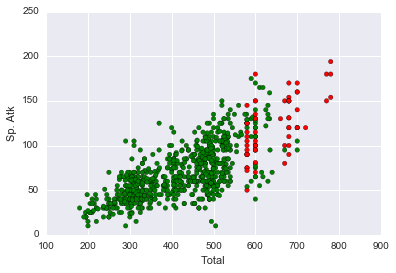

In [60]:
df['Legendary'] = df.Legendary

cmap = {'True': 'r', 'False': 'g'}

df['ctarget'] = df.Legendary.apply(lambda x: cmap[str (x)])

df.plot('Total','Sp. Atk', kind = 'scatter', c = df.ctarget)

In [61]:
def my_classifier(row):
    if row['Total'] < 580:
        return False
    else:
        return True

predictions = df.apply(my_classifier, axis=1)

df['predictions'] = predictions

print float(len(df[df.Legendary == df.predictions])) / len(df)

0.94


Total score of less than 580 predicts is accurate 94% of the time. 

BUILDING A CLASSIFIER FOR WHAT TYPE IS THE POKEMON ????

In [91]:
df.groupby(['Type 1'])[['Total']].mean()


,Total
Type 1,
Bug,378.927536
Dark,445.741935
Dragon,550.531250
Electric,443.409091
Fairy,413.176471
Fighting,416.444444
Fire,458.076923
Flying,485.000000
Ghost,439.562500


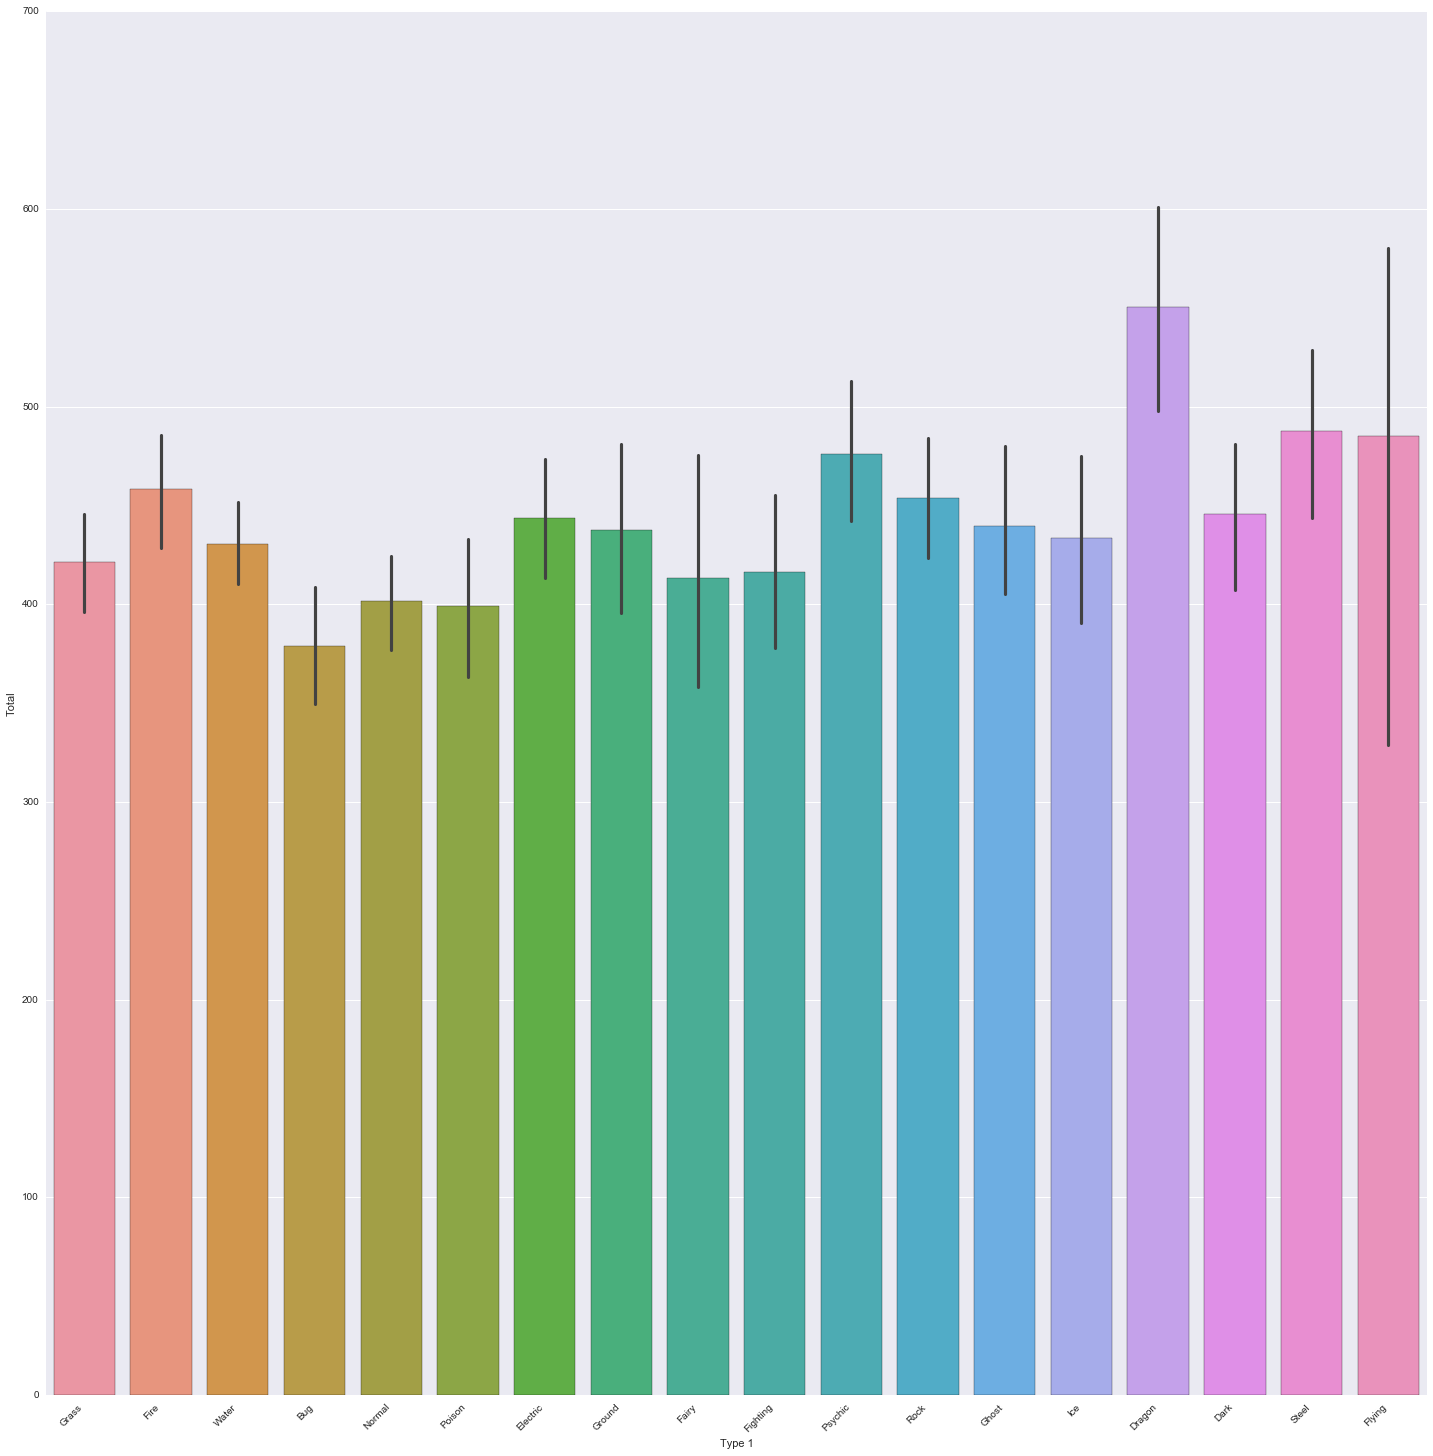

In [90]:
#Looking at the mean of the total score for each type of Pokemon

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='Type 1', 
              y='Total',
              kind='bar',
              data = df,
              size = 20
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

KNN FOR TYPE of POKEMON

In [81]:
from sklearn import datasets, neighbors, metrics
import pandas as pd

Type = df['Type 1']
msk = np.random.rand(len(df_metrics)) < 0.8
df_metrics = df.drop(['Type 1','Type 2', 'predictions', 'ctarget'],1) #dropped columns that have no impact on the model
Xtrain = df_metrics[msk]
Ytrain = Type[msk]

Xtest = df_metrics[~msk]
Ytest = Type[~msk]

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm = 'kd_tree')

knn.fit(Xtrain, Ytrain)
print knn.predict(Xtest)
print Ytest.head()

['Bug' 'Normal' 'Fire' 'Water' 'Water' 'Normal' 'Steel' 'Fire' 'Normal'
 'Grass' 'Water' 'Rock' 'Dark' 'Bug' 'Normal' 'Dragon' 'Psychic' 'Grass'
 'Bug' 'Electric' 'Dragon' 'Fire' 'Grass' 'Rock' 'Normal' 'Bug' 'Rock'
 'Fire' 'Rock' 'Normal' 'Normal' 'Bug' 'Grass' 'Rock' 'Rock' 'Electric'
 'Ghost' 'Water' 'Water' 'Fire' 'Flying' 'Water' 'Fighting' 'Dark' 'Bug'
 'Grass' 'Grass' 'Grass' 'Dark' 'Normal' 'Dragon' 'Bug' 'Normal' 'Poison'
 'Steel' 'Grass' 'Bug' 'Grass' 'Poison' 'Fairy' 'Fire' 'Psychic' 'Bug'
 'Electric' 'Poison' 'Grass' 'Water' 'Water' 'Steel' 'Psychic' 'Dragon'
 'Water' 'Fire' 'Ground' 'Bug' 'Normal' 'Ground' 'Electric' 'Fire' 'Normal'
 'Dragon' 'Normal' 'Ghost' 'Poison' 'Water' 'Normal' 'Fire' 'Fire' 'Ghost'
 'Steel' 'Electric' 'Psychic' 'Poison' 'Rock' 'Fire' 'Poison' 'Rock' 'Bug'
 'Ghost' 'Rock' 'Water' 'Normal' 'Grass' 'Ghost' 'Normal' 'Water' 'Water'
 'Poison' 'Water' 'Water' 'Ice' 'Bug' 'Fighting' 'Ghost' 'Electric' 'Water'
 'Bug' 'Poison' 'Normal' 'Bug' 'Water' 'Psychi

In [82]:
print knn.score(Xtest, Ytest)

0.214285714286


GRIDSEARCH ON KNN

In [101]:
from sklearn import grid_search, cross_validation
import matplotlib.pyplot as plt
X = df_metrics
Y = Type

k = range(2, 100)
params = {'n_neighbors': k }
kf = cross_validation.KFold(len(df_metrics), n_folds = 3)
gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid=params,
    cv=kf,
)
gs.fit(X, Y)
gs.grid_scores_

[mean: 0.17875, std: 0.02863, params: {'n_neighbors': 2},
 mean: 0.17625, std: 0.00946, params: {'n_neighbors': 3},
 mean: 0.17375, std: 0.02073, params: {'n_neighbors': 4},
 mean: 0.18125, std: 0.02652, params: {'n_neighbors': 5},
 mean: 0.19625, std: 0.01126, params: {'n_neighbors': 6},
 mean: 0.19375, std: 0.01243, params: {'n_neighbors': 7},
 mean: 0.21000, std: 0.01586, params: {'n_neighbors': 8},
 mean: 0.22125, std: 0.01297, params: {'n_neighbors': 9},
 mean: 0.21750, std: 0.01298, params: {'n_neighbors': 10},
 mean: 0.21750, std: 0.01670, params: {'n_neighbors': 11},
 mean: 0.21625, std: 0.02266, params: {'n_neighbors': 12},
 mean: 0.22250, std: 0.02647, params: {'n_neighbors': 13},
 mean: 0.21250, std: 0.02426, params: {'n_neighbors': 14},
 mean: 0.21375, std: 0.01979, params: {'n_neighbors': 15},
 mean: 0.20875, std: 0.02732, params: {'n_neighbors': 16},
 mean: 0.20000, std: 0.03038, params: {'n_neighbors': 17},
 mean: 0.20375, std: 0.03215, params: {'n_neighbors': 18},
 mean

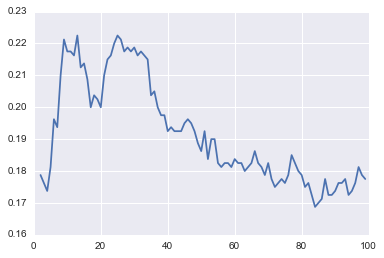

In [102]:
plt.plot(k,[s[1] for s in  gs.grid_scores_],)

In [96]:
gs.best_params_

{'n_neighbors': 13}

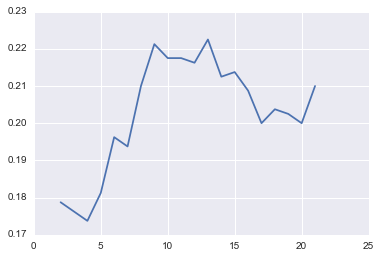

In [97]:
plt.plot(k[:20],[s[1] for s in  gs.grid_scores_][:20],)

The accuracy score of the KNN with 13 neighbors is .2225

In [110]:
from sklearn import grid_search, cross_validation
import matplotlib.pyplot as plt
X = df_metrics
Y = Type

k = range(2, 100)
params2 = {'n_neighbors': k, 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights':['uniform', 'distance'] }
kf = cross_validation.KFold(len(df_metrics), n_folds = 3)
gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid=params2,
    cv=kf,
)
gs.fit(X, Y)
gs.grid_scores_

[mean: 0.17875, std: 0.02863, params: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.18250, std: 0.01542, params: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.17625, std: 0.00946, params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.18375, std: 0.01832, params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.17375, std: 0.02073, params: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.19125, std: 0.02587, params: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.18125, std: 0.02652, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.20125, std: 0.01839, params: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.19625, std: 0.01126, params: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.20750, std: 0.01814, params: {'n_neighbors': 6, 'weights': 'distance', 'algori

In [111]:
gs.best_params_

{'algorithm': 'brute', 'n_neighbors': 37, 'weights': 'distance'}

The score using the best params is .2425

In [112]:
df.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ctarget,predictions
0,Grass,Poison,318,45,49,49,65,65,45,1,False,g,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False,g,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False,g,False
3,Grass,Poison,625,80,100,123,122,120,80,1,False,g,True
4,Fire,NaN,309,39,52,43,60,50,65,1,False,g,False


DECISION TREE

In [122]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4,
                              min_samples_leaf = 5)

X1 = df[['Total', 'HP', 'Defense']].dropna()
Y1 = df['Type 1']
    
# Fits the model
model.fit(X1, Y1)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [123]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X1, Y1, scoring='roc_auc', cv=2)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

ValueError: multiclass format is not supported

In [124]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X1, Y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X1, Y1, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

ValueError: multiclass format is not supported

In [126]:
X1.head()

,Total,HP,Defense
0,318,45,49
1,405,60,63
2,525,80,83
3,625,80,123
4,309,39,43


In [127]:
Y1.head()

0    Grass
1    Grass
2    Grass
3    Grass
4     Fire
Name: Type 1, dtype: object

In [129]:

if Grass:
    return 1
elif Fire:
    return 2
elif Bug:
    return 3


SyntaxError: 'return' outside function (<ipython-input-129-4c341b50692c>, line 3)

In [ ]:
df.new_type1 = df['Type 1'].apply 